In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from skimage import measure

In [2]:
import os
print(os.listdir("../data"))

['train_labels.csv', '.DS_Store', 'train_images.npy', 'test_images.npy']


In [3]:
#Entire images and labels
images_train = np.load('../data/train_images.npy', encoding='latin1')
IMAGE_T = np.load('../data/train_images.npy', encoding='latin1')
IMAGE_T = IMAGE_T[:,1]
IMAGE_T = IMAGE_T.tolist()
train_im = np.load('../data/train_images.npy', encoding='latin1')
train_im = train_im[:,1]
train_im = train_im.tolist()
images_train = images_train[:,1]
images_train = images_train.tolist()
for i in range(len(train_im)):
    train_im[i]=train_im[i].reshape(100,100)
for i in range(len(images_train)):
    images_train[i]=images_train[i].reshape(100,100)    
for i in range(len(IMAGE_T)):
    IMAGE_T[i] = IMAGE_T[i].reshape(100,100)
import csv
import string
with open('../data/train_labels.csv') as f:
    reader = csv.reader(f, delimiter=",")
    label_train = list(reader)   
del label_train[0]

In [4]:
#Carve around contours with maximum length. Noise around any enclosed contour is removed
contour=[]
image_crop = []
for j in range(len(images_train)):
    contour.append(measure.find_contours(images_train[j],0.1))
    chang = []
    c=0
    for n,i in enumerate(contour[j]):
        chang.append(len(i))
        if len(i)>c:
            c = len(i)
            idx = n
    for i in contour[j]:
        if len(i)<sorted(chang)[-2]:
            ymin = int(round(min(i[:,0])))
            xmin = int(round(min(i[:,1])))
            ymax = int(round(max(i[:,0])))
            xmax = int(round(max(i[:,1])))
            IMAGE_T[j][ymin:ymax,xmin:xmax] = np.zeros_like(IMAGE_T[j][ymin:ymax,xmin:xmax])
    r_mask = np.zeros_like(images_train[j],dtype='bool')
    r_mask[np.round(contour[j][idx][:, 0]).astype('int'), np.round(contour[j][idx][:, 1]).astype('int')] = 1
    r_mask = ndimage.binary_fill_holes(r_mask)
    for k in range(0,r_mask.shape[0]):
        for l in range(0,r_mask.shape[1]):
            if r_mask[k,l]==0:
                images_train[j][k,l] = 0
    ymin = int(round(min(contour[j][idx][:,0])))
    xmin = int(round(min(contour[j][idx][:,1])))
    ymax = int(round(max(contour[j][idx][:,0])))
    xmax = int(round(max(contour[j][idx][:,1])))
    temp_crop = IMAGE_T[j][ymin+1:ymax-1,xmin+1:xmax-1]
    if np.count_nonzero(temp_crop)>np.count_nonzero(images_train[j][ymin+1:ymax-1,xmin+1:xmax-1]):
        image_crop.append(temp_crop)
    else:
        image_crop.append(images_train[j][ymin+1:ymax-1,xmin+1:xmax-1])

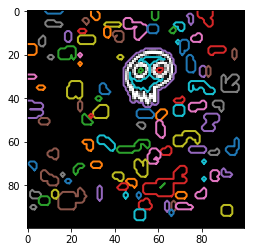

In [5]:
j=170
image1 = IMAGE_T[j]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image1, interpolation='nearest', cmap=plt.cm.gray)

for n, i in enumerate(contour[j]):
    ax.plot(i[:, 1], i[:, 0], linewidth=2)

In [6]:
changdu=[]
for i in contour[1797]:
    changdu.append(len(i))
print(sorted(changdu)[-2])


81


In [7]:
#Extract height, width, edges, gradient, and gradient direction from cropped image 
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from skimage import feature

image_size = []
image_norm = []
ver_grad = []
hor_grad = []
ver_max = []
hor_max = []
grad_mag = []
for i in image_crop:
    image_size.append(i.size)
    image_norm.append(resize(i,(30,30), anti_aliasing = True, mode='constant'))
for i in image_norm:
    v_grad = np.pad(i,((1,0),(0,0)),mode='constant')
    ve_grad = np.diff(v_grad,axis=0)
    ver_grad.append(ve_grad)
    h_grad = np.pad(i,((0,0),(1,0)),mode='constant')
    ho_grad = np.diff(h_grad,axis=1)
    hor_grad.append(ho_grad)
    for i in range(0,ho_grad.shape[0]):
        for j in range(0,ho_grad.shape[1]):
            if ho_grad[i,j]>ho_grad[i,j-1]:
                ho_grad[i,j-1]=0
            else:
                    ho_grad[i,j]=0
    hor_max.append(ho_grad)
    for i in range(0,ve_grad.shape[0]):
        for j in range(0,ve_grad.shape[1]):
            if ve_grad[i,j]>ho_grad[i-1,j]:
                ve_grad[i-1,j]=0
            else:
                    ve_grad[i,j]=0
    ver_max.append(ve_grad)
    grad_magni = ve_grad+ho_grad
    for i in range(0,grad_magni.shape[0]):
        for j in range(0,grad_magni.shape[1]):
            if grad_magni[i,j] > 0:
                grad_magni[i,j]=255
    grad_mag.append(grad_magni)

#Gradient angle
edge_angle=[]
for i in range(len(hor_grad)):
    edge_angle.append(np.arctan2(hor_grad[i], ver_grad[i]))

In [26]:
#Make a list that consists of the size of image and edge angle information

edge_angle_row=[]
for i in range(len(edge_angle)):
    edge_angle_row.append(edge_angle[i].reshape(edge_angle[i].size))
    edge_angle_row[i] = [image_size[i]]+edge_angle_row[i].tolist()
with open('processed_train.txt', 'w') as f:
    for item in edge_angle_row:
        f.write("\n")
        for ftem in item:
            f.write("%s, " %ftem)

In [17]:
print(edge_angle_row[1])

300


In [9]:
j=[]
for i in range(len(edge_angle)):
    j.append(sum(sum(edge_angle[i])))
print(max(j))

370.71147061113135


['170', 'skull']
196


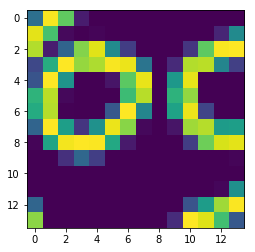

In [10]:
i=170
plt.imshow(image_crop[i])
print(label_train[i])
print(image_crop[i].size)


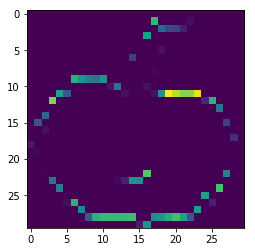

In [11]:
plt.imshow(ver_grad[3])

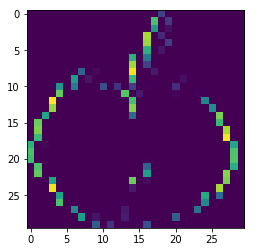

In [12]:
plt.imshow(hor_grad[3])

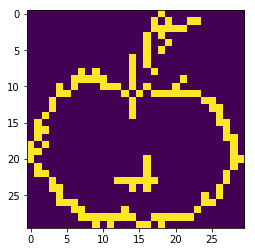

In [13]:
plt.imshow(grad_mag[3])

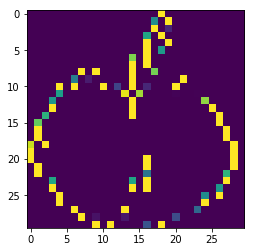

In [14]:
plt.imshow(edge_angle[3])